In [1]:
# import the necessary packages
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os

In [49]:
def removeNegatives(dataset):

    for col in dataset.columns.tolist()[1:]:
        dataset = dataset[dataset[col] > 0]

    return dataset

In [50]:
#Merge Youtube faces training and test dataset
def mergeYoutubeCSVs(csvPath):
    
    testPath = os.path.join(csvPath,"test_frames_keypoints.csv")
    testDataset = pd.read_csv(testPath)
    
    for i in range(testDataset.shape[0]):
        testDataset.iloc[i,0] = "test/"+testDataset.iloc[i,0]
    
    trainPath = os.path.join(csvPath,"training_frames_keypoints.csv")
    trainDataset = pd.read_csv(trainPath)

    
    for i in range(trainDataset.shape[0]):
        trainDataset.iloc[i,0] = "training/"+trainDataset.iloc[i,0]

    #Concatenate training and test set
    dataset = pd.concat([trainDataset, testDataset], ignore_index=True)
    #Change column names
    cols = ["Path"]
    for i in range(136):
        cols.append("Land{}".format(i))
    dataset.columns = cols
    dataset = removeNegatives(dataset)
    #Save to csv
    datasetPath = os.path.join(csvPath,"Youtube.csv")
    dataset.to_csv(datasetPath, index=False)

mergeYoutubeCSVs("data/Youtube")

In [51]:
#Crop images around square bounding box
def getBoundingBoxes(csvPath):
    
    path = os.path.join(csvPath,"Youtube.csv")
    dataset = pd.read_csv(path)
    
    #For each image in the dataset
    for i in range(dataset.shape[0]):

        #Get image
        imgPath = os.path.join(csvPath,dataset.iloc[i,0])
        ori_image = cv2.imread(imgPath)

        #Get points
        points = dataset.iloc[i,1:].to_numpy()
        points = points.astype('float').reshape((int(points.shape[0]/2),2))
        
        #Compute the BB
        x, y = np.min(points, axis =0)
        maxX, maxY = np.max(points, axis =0)

        w = maxX - x
        h = maxY - y

        #Leave more space around the landmarks
        if(x>=10):
            x-=10
            w+=20
        else:
            w+=10
        if(y>=10):
            y-=10
            h+=20
        else:
            y+=10

        #Make it square
        if(w>h):
            if(y>=((w-h)/2)):
                y-=(w-h)/2
            h = w

        else:
            if(x>=((h-w)/2)):
                x-=(h-w)/2
            w = h

        if((int(y+h)-int(y)) < (int(x+w)-int(x))):
            h+=1
        elif((int(y+h)-int(y)) > (int(x+w)-int(x))):
            w+=1
    
    
    
        #Save cropped image around BB
        bb_file= os.path.join(csvPath,"cropped/"+dataset.iloc[i,0])

        roi = ori_image[int(y):int(y+h), int(x):int(x+w)]
        cv2.imwrite(bb_file, roi)

        #Modify landmark values and save them
        points = points - np.array([x,y])
        points = np.around(points, decimals=3)
        points = points.flatten()
        dataset.iloc[i,1:] = points
        
    dataset.to_csv(os.path.join(csvPath,"cropped/Youtube.csv"), index=False)

getBoundingBoxes("data/Youtube")

In [8]:
def merge300W_YT(dataPath):
    
    path1 = os.path.join(dataPath, "300W/300W.csv")
    path2 = os.path.join(dataPath,"Youtube/Youtube.csv")

    dataset1 = pd.read_csv(path1)
    dataset2 = pd.read_csv(path2)
    
    image_paths1 = dataset1.iloc[:, 0].to_numpy()
    image_paths2 = dataset2.iloc[:, 0].to_numpy()
    
    print(image_paths1.shape)
    print(image_paths2.shape)
    
    print(np.hstack((image_paths1,image_paths2)).shape)
    
    landmarks1 = dataset1.iloc[:, 1:].to_numpy()
    landmarks2 = dataset2.iloc[:, 1:].to_numpy()
    
    print(landmarks1.shape)
    print(landmarks2.shape)
    
    print(np.vstack((landmarks1,landmarks2)).shape)

merge300W_YT("data")

(600,)
(4227,)
(4827,)
(600, 136)
(4227, 136)
(4827, 136)


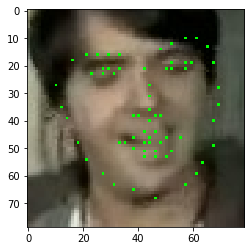

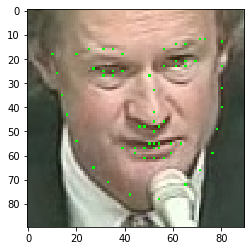

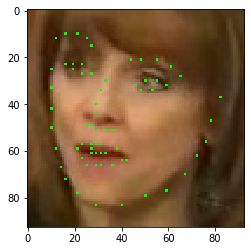

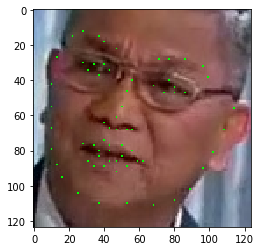

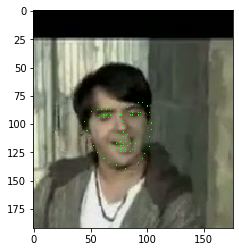

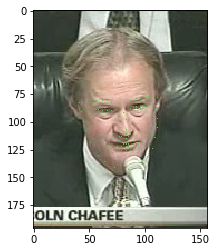

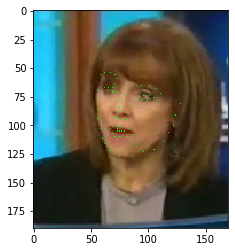

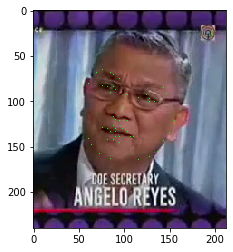

In [55]:
#Test is the cropping and rescaling of the points was correct
def printPoints(image_file, points):
    
    points = points.reshape((int(points.shape[0]/2),2))
    
    ori_image = cv2.imread(image_file)

    for (x, y) in points:
        cv2.circle(ori_image, (int(x),int(y)), 0, (0, 255, 0), -1)

    plt.imshow(cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB))
    plt.show()

dataset = pd.read_csv("data/Youtube/cropped/Youtube.csv")
for i in range(4):
    printPoints("data/Youtube/cropped/"+dataset.iloc[i,0], dataset.iloc[i,1:].to_numpy())
    
dataset = pd.read_csv("data/Youtube/Youtube.csv")
for i in range(4):
    printPoints("data/Youtube/"+dataset.iloc[i,0], dataset.iloc[i,1:].to_numpy())